In [1]:
from pydub import AudioSegment
from pydub import effects
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#instead of taking each music value at each timestep, can use small sections of music values to run probability matrices for 
#use MLE to normal distribution parameters to the music sample and use that normal distribution as our acceptance function
#get 20 3 second clips from song 

random_starts = np.random.randint(60000, size=7)

random_clips = [AudioSegment.from_file("../music/cellophane.mp3", format="mp3")[clip:clip+3000].set_frame_rate(2200) for clip in random_starts]

# song = AudioSegment.from_file("../music/xxintro.mp3", format="mp3")[four_seconds:seven_seconds]

In [2]:
#spawn new sound clip given array
def spawn_clip(sound, array):
    return sound._spawn(array)

In [3]:
array = random_clips[0]

new_sound = spawn_clip(random_clips[0], random_clips[0].get_array_of_samples())
new_sound

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


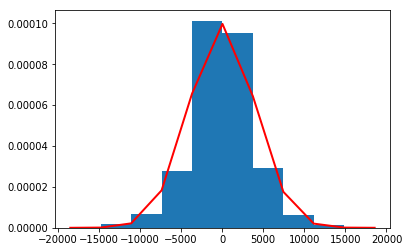

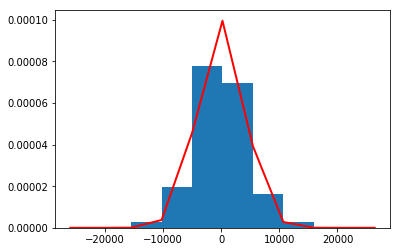

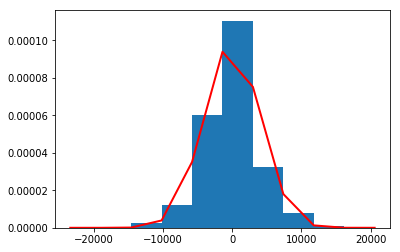

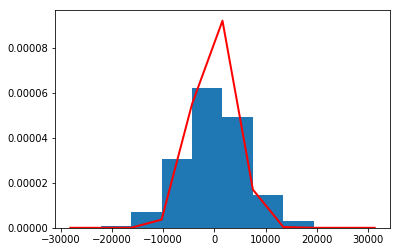

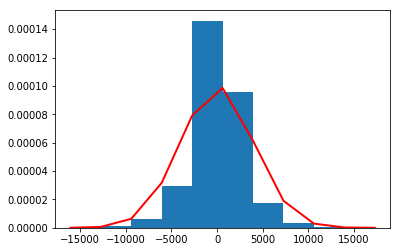

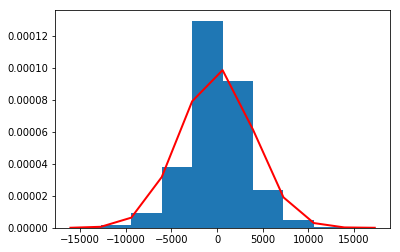

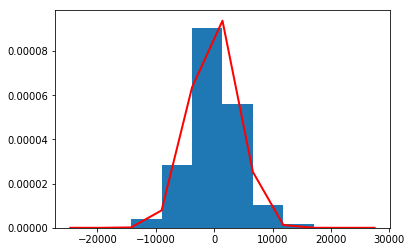

In [4]:
mu = 0
sigma = 4000

for clip in random_clips:
    arr = clip.get_array_of_samples()
    
    count, bins, ignored = plt.hist(arr, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
    plt.show()

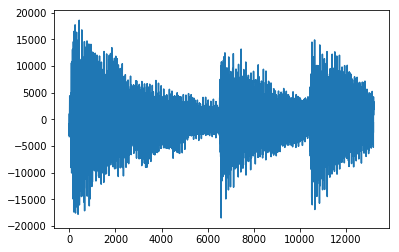

[7451, 11399]


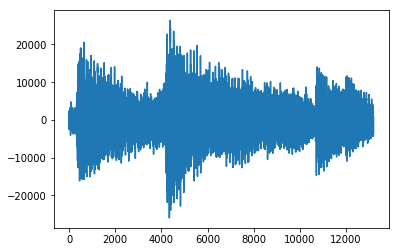

[4431, 6087]


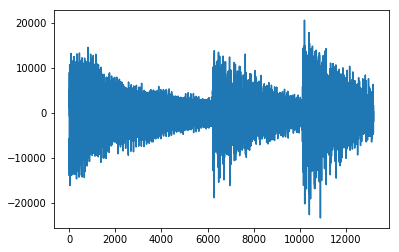

[7637, 10203]


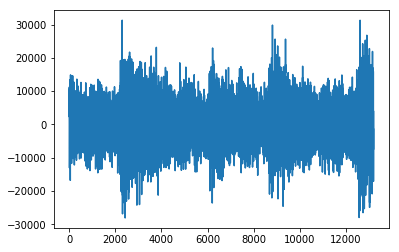

[2313, 8929]


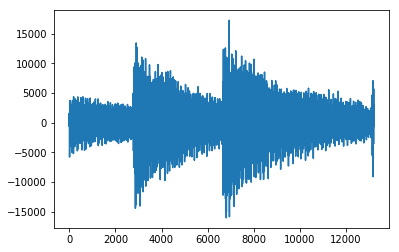

[2903, 6935]


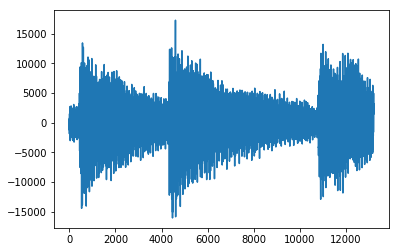

[4603, 10913]


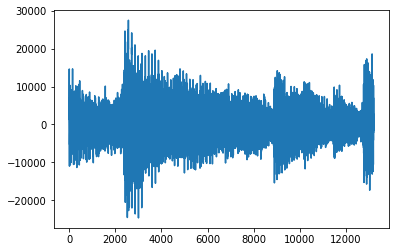

[2569, 3591]
21


In [5]:
#Method 1 for creating music note groupings - try and find sudden changes in notes to capture each note

note_dictionary1 = {}
i = 0
for clip in random_clips:
    arr = clip.get_array_of_samples()
    plt.plot(arr)
    plt.show()

    test_array = clip.get_array_of_samples()
    diff_array = [abs(abs(test_array[i+1]) - abs(test_array[i])) for i in range(len(test_array) - 1)]
    #print(np.array(diff_array).argsort()[::-1])
    
    storedVals = []
    divPoints = []

    for x in np.array(diff_array).argsort()[::-1]:
        if str(x)[0] not in storedVals and x > 1000 and x < 12000:
            storedVals.append(str(x)[0])
            divPoints.append(x)
    shortList = divPoints[:2]
    shortList.sort()
    print(shortList)

    
    note_dictionary1[str(i)] = test_array[0:shortList[0]]
    note_dictionary1[str(i+1)] = test_array[shortList[0]:shortList[1]]
    note_dictionary1[str(i +2)] = test_array[shortList[1]:]
    i += 3
    # print(test_array[3800:4100])
    spawn_clip(clip, arr[7438:])

    
print(len(note_dictionary1))

2.711828103570315e-06
[[0.         1.         0.26700602 0.         0.10226075 0.50160393
  0.         0.11958397 0.0922102  0.         0.29272912 0.21744134
  0.         0.6018113  0.29114968 0.         0.55293011 0.38732553
  0.         0.23506328 0.25397413]
 [0.         0.         1.         0.         0.57572943 0.02579275
  0.         0.25270957 0.02780197 0.         0.38593902 0.43801549
  0.         0.76463319 0.35992725 0.         0.78335484 0.72900753
  0.         0.79628596 0.64248346]
 [0.         0.57815527 0.         0.         0.62144836 0.54350439
  0.         0.50339066 0.14635307 0.         0.84593709 0.48219568
  0.         0.99407363 0.81886611 0.         0.92565365 0.84115836
  0.         0.57482658 0.32027185]
 [0.         0.10226075 0.57572943 0.         1.         0.47399315
  0.         0.39822689 0.41095124 0.         0.32447156 0.19898943
  0.         0.89431263 0.60696824 0.         0.0674872  0.60611939
  0.         0.19576309 0.38887468]
 [0.         0.501

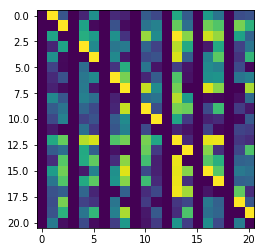

In [6]:
def generate(n, note_dict):
    shape = (n, n)
    mat = np.zeros(shape)
    
    arr = []
    
    for i in range(n-1):
        for j in range(n):
            if not(i % 3 == 2 or j == i+1):
                sim = similarity(note_dict[str(j)], note_dict[str(i)])
                arr.append(sim)
                mat[j][i+1] = sim 
    
    for i in range(n):
        if i % 3 != 2:
            mat[i][i+1] = 1
    
    max_small = max(arr)
    print(max_small)
    
    for i in range(n):
        for j in range(n):
            if mat[i][j] < 1:
                mat[i][j] /= max_small
                mat[i][j] = abs(mat[i][j])
                mat[i][j] = normalize(mat[i][j])
    
    return mat

def similarity(arr1, arr2):
    l1 = len(arr1)
    l2 = len(arr2)
    
    if l1 < l2:
        arr1.extend([0 for _ in range(l2-l1)])
    elif l1 > l2:
        arr2.extend([0 for _ in range(l1-l2)])

    dot = np.dot(arr1, arr2)
    normalization = np.linalg.norm(arr1) * np.linalg.norm(arr2)
    return dot / normalization

#0 to 1 -> push closer to 1
def normalize(x):
    return 2.0 / (1 + np.exp(-10 * x)) - 1

mat = generate(len(note_dictionary1), note_dictionary1)
plt.imshow(mat)

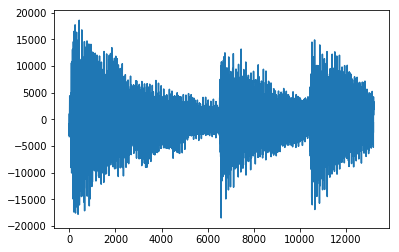

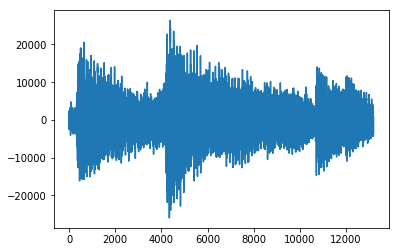

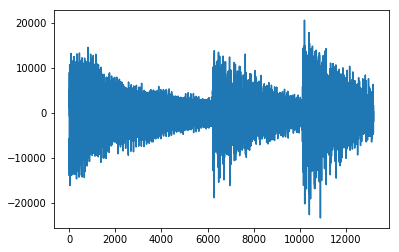

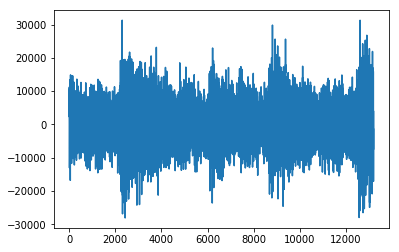

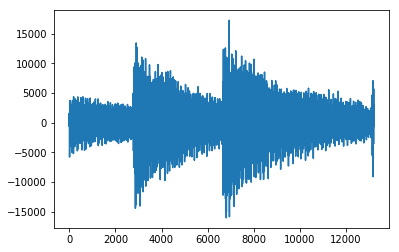

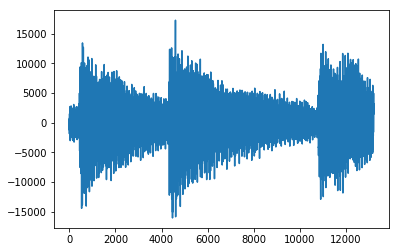

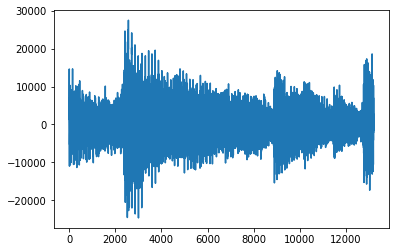

In [7]:
#Method 2 for creating music note groupings - three even splits for three second sample

note_dictionary2 = {}
i = 0
for clip in random_clips:
    arr = clip.get_array_of_samples()
    plt.plot(arr)
    plt.show()

    test_array = clip.get_array_of_samples()
    
    note_dictionary2[str(i)] = test_array[0:4400]
    note_dictionary2[str(i+1)] = test_array[4400:8800]
    note_dictionary2[str(i +2)] = test_array[8800:13200]
    i += 3
    # print(test_array[3800:4100])
    spawn_clip(clip, arr[7438:])

In [8]:
# aveClips = np.sum([clip.get_array_of_samples() for clip in random_clips], axis=0)/20
# print(aveClips)
# spawn_clip(random_clips[9], aveClips)

Task List

probability of 1 for given data indexes above that we know are right after each other but then have to construct a decreasing function with respect to increasing L2 distance for all indexes to every other index and its known next data value 

For example, say we know that index 2 follows index 1 with probability 1 from the data, then we would take the index i for all i, measure the distance from index 1's vector to that of index i's vector and based on how far these vectors are, assign a probability to the transition from index i to index 2. The larger the distance from index 1, the smaller the probability of that transition should be

1. Split up 3 second music signals into effective groupings based on amplitude changes
2. Create dictionary mapping between our grouping index and array of music signal values of grouping
3. Further the L2 norm of grouping signal value array is from another array, it will have a smaller probability value of transitioning to the next array that the other array goes to. The other array has a probability of 1 of transitioning to the next music grouping 
4. In the end we do MCMC with just the integers representing the music groupings 
5. Add normal distribution (parameters found through MLE) to add to the acceptance function to make sure all values of music array being created is still normal - might be implied since we are doing MCMC over index integers

<class 'array.array'>


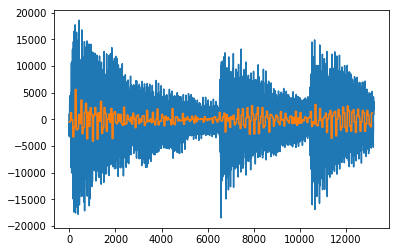

In [9]:
#Attempt to do a running average of music signal

arr = new_sound.get_array_of_samples()
averageVals = []

for i in range(0,len(arr)-50,50):
    sumTotal = np.sum(arr[i:i + 50])
    averageVals += [sumTotal/50] * 50

averageVals = [v*4 for v in averageVals]
plt.plot(arr)
print(type(arr))
plt.plot(averageVals)
spawn_clip(new_sound, arr)
spawn_clip(new_sound, averageVals)

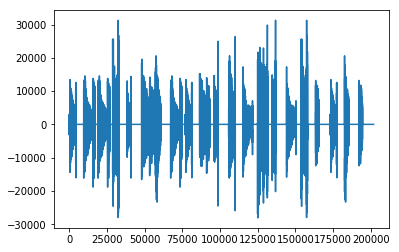

In [10]:
import array

finalArray = np.random.randint(1,21,21)

finalMusic = []

for note in finalArray:
    finalMusic += note_dictionary1[str(note)]


plt.plot(finalMusic)
spawn_clip(new_sound, array.array('h', finalMusic))
